# Car Price Prediction

Project Report by Allentine Paulis

# Table of Contents
* [Project Description](#description)
* [Project Instructions](#instruction)
* [Data](#data)
* [Step 1. Data Preparation](#preparation)
* [Step 2. Data Preprocessing](#preprocessing)
* [Step 3. Model Training](#training)
* [Step 4. Model Analysis](#analysis)  
* [Step 5. Overall conclusion](#allconclusion)

# Project Description <a class="anchor" id="description"></a>
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

# Project instructions <a class="anchor" id="instruction"></a>
1. Look at the data.
2. Train different models with various hyperparameters (We should make at least two different models, but more is better. Remember, various implementations of gradient boosting don't count as different models.) The main point of this step is to compare gradient boosting methods with random forest, decision tree, and linear regression.
3. Analyze the speed and quality of the models.

                                                        
Notes:
- Use the RMSE metric to evaluate the models.
- Linear regression is not very good for hyperparameter tuning, but it is perfect for doing a sanity check of other methods. If gradient boosting performs worse than linear regression, something definitely went wrong.
- Work with the LightGBM library and use its tools to build gradient boosting models.
- Ideally, the project should include linear regression for a sanity check, a tree-based algorithm with hyperparameter tuning (preferably, random forrest), LightGBM with hyperparameter tuning (try a couple of sets), and CatBoost and XGBoost with hyperparameter tuning (optional).
- Take note of the encoding of categorical features for simple algorithms. LightGBM and CatBoost have their implementation, but XGBoost requires OHE.
- We can use a special command to find the cell code runtime in Jupyter Notebook. Find that command.
- Since the training of a gradient boosting model can take a long time, change only a few model parameters.


# Data <a class="anchor" id="data"></a>
The dataset is stored in https://code.s3.yandex.net/datasets/car_data.csv

**Features**
- *DateCrawled* — date profile was downloaded from the database
- *VehicleType* — vehicle body type
- *RegistrationYear* — vehicle registration year
- *Gearbox* — gearbox type
- *Power* — power (hp)
- *Model* — vehicle model
- *Mileage* — mileage (measured in km due to dataset's regional specifics)
- *RegistrationMonth* — vehicle registration month
- *FuelType* — fuel type
- *Brand* — vehicle brand
- *NotRepaired* — vehicle repaired or not
- *DateCreated* — date of profile creation
- *NumberOfPictures* — number of vehicle pictures
- *PostalCode* — postal code of profile owner (user)
- *LastSeen* — date of the last activity of the user


**Target**
- *Price* — price (Euro)

## Data preparation <a class="anchor" id="preparation"></a>

In [1]:
import math
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, precision_score 
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from catboost import CatBoostClassifier,CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv("https://code.s3.yandex.net/datasets/car_data.csv")

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
df.dtypes

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Mileage               int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode            int64
LastSeen             object
dtype: object

The date data types in DateCrawled, Data Created, Last Seen columns need to be changed into datetime data type.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


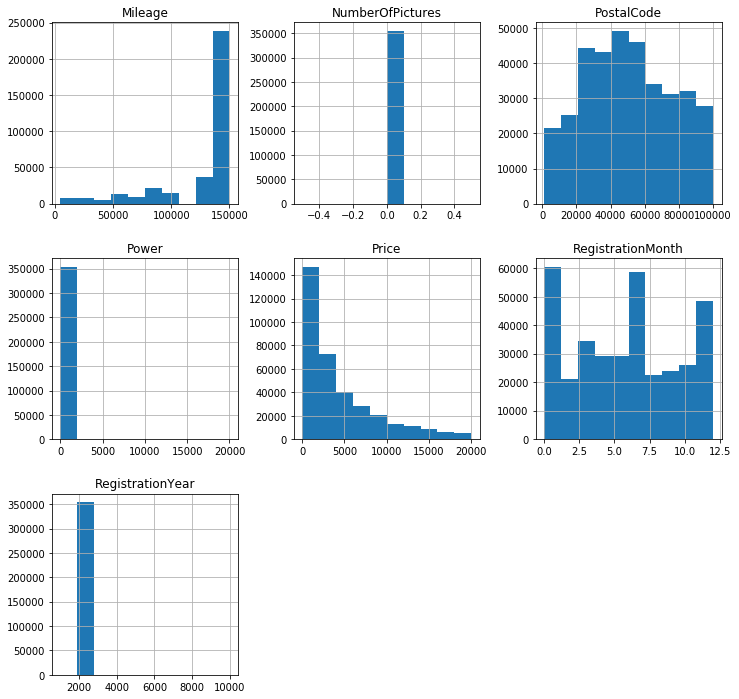

In [7]:
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df.hist(ax = ax)
plt.show()

I'm checking briefly the graph to figure out quickly what's going on so I can check the detail below, for example there is weird graph with NumberOfPictures seem only have 1 value or why there are lot of zero in Power, why there is 0 in registration month.

In [8]:
missing_values = df.isnull().sum()
missing_values

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
missing_percent = df.isnull().sum()/len(df) * 100
missing_percent

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [10]:
missing_table = pd.concat([missing_values, missing_percent], axis=1)
missing_table = missing_table.rename(columns={0: 'MissingValues', 1:'Missing%'})
missing_table = missing_table[missing_table.iloc[:,1]!=0].sort_values('Missing%', ascending=False).round(2)
missing_table

,MissingValues,Missing%
NotRepaired,71154,20.08
VehicleType,37490,10.58
FuelType,32895,9.28
Gearbox,19833,5.60
Model,19705,5.56


We have missing values from 5 columns.

In [11]:
df.duplicated().sum()

262

There is 262 duplicates.

In [12]:
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Why only have 0 values.

In [13]:
df['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

'Yes' can be replaced with 1. 'No' can be replaced with 0. The missing values can be replaced with 0, since most likely users who filled out the "Was the car repaired" form simply did not fill out if it was not repaired. Let's assume that the missing values was 0.

In [14]:
df['Power'].value_counts()

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
16311        1
1360         1
1968         1
6226         1
6006         1
Name: Power, Length: 712, dtype: int64

In [15]:
df['Power'].value_counts()/len(df)*100

0        11.351162
75        6.779092
60        4.486002
150       4.117177
101       3.752586
           ...    
16311     0.000282
1360      0.000282
1968      0.000282
6226      0.000282
6006      0.000282
Name: Power, Length: 712, dtype: float64

Power should not be 0 and it has 11% of data. We can fill it with average or ffill.

In [16]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

There are weird registration year for the car such as 3200, 8200, 8455, 9000 etc

In [17]:
df['PostalCode'].value_counts()

10115    819
65428    613
66333    343
44145    317
32257    317
        ... 
6725       1
6922       1
85071      1
97528      1
63931      1
Name: PostalCode, Length: 8143, dtype: int64

This postal code doesn't seem needed for the model training, so we can drop them.

### Conclusion

- There are 16 columns and 354369 rows.
- We have missing values from 5 columns which are:
    - NotRepaired: 71154 rows which is 20.08%
    - VehicleType : 37490 rows which is 10.58% 
    - FuelType: 32895 rows which is 9.28%
    - Gearbox : 19833 rows which is 5.59%
    - Model: 19705 rows which is 5.56%
- The date data types in DateCrawled, Data Created, Last Seen columns need to be changed into datetime data type. However datetime columns doesn't seem needed for the model training so we can drop them.
- There are 262 duplicated rows.
- All number of pictures are zero, so we can drop them.
- Postal Code doesn't seem needed, so we can drop them.
- NotRepaired column can be replaced yes with 1 and no with 0 and the missing values can be replaced with 0, since most likely users who filled out the "Was the car repaired" form simply did not fill out if it was not repaired. For this reason, let's assume that the missing values are zero.
- There are lot of zero Power. Power should not be 0 and it has 11% of data. We can fill it with average or ffill.
- There are weird and extreme values of registration year for the car

## Data preprocessing <a class="anchor" id="preprocessing"></a>

In [18]:
df['DateCrawled']= pd.to_datetime(df['DateCrawled'], format='%d/%m/%Y %H:%M')
df['DateCreated']= pd.to_datetime(df['DateCreated'], format='%d/%m/%Y %H:%M')
df['LastSeen']= pd.to_datetime(df['LastSeen'], format='%d/%m/%Y %H:%M')

checking if years are relevant on the dates columns

In [19]:
print('--------------- DateCrawled ---------------')
df['year_crawled'] = pd.DatetimeIndex(df['DateCrawled']).year
df['year_crawled'] = df['year_crawled'].astype('Int32')
print(df['year_crawled'].describe())

print('--------------- DateCreated ---------------')
df['year_created'] = pd.DatetimeIndex(df['DateCreated']).year
df['year_created'] = df['year_created'].astype('Int32')
print(df['year_created'].describe())

print('--------------- LastSeen ---------------')
df['year_lastSeen'] = pd.DatetimeIndex(df['LastSeen']).year
df['year_lastSeen'] = df['year_lastSeen'].astype('Int32')
print(df['year_lastSeen'].describe())

--------------- DateCrawled ---------------
count    354369.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: year_crawled, dtype: float64
--------------- DateCreated ---------------
count    354369.000000
mean       2015.999924
std           0.009046
min        2014.000000
25%        2016.000000
50%        2016.000000
75%        2016.000000
max        2016.000000
Name: year_created, dtype: float64
--------------- LastSeen ---------------
count    354369.0
mean       2016.0
std           0.0
min        2016.0
25%        2016.0
50%        2016.0
75%        2016.0
max        2016.0
Name: year_lastSeen, dtype: float64


In [20]:
# years seems irrelevant, we will drop them
df = df.drop(columns=['year_crawled', 'year_created', 'year_lastSeen'])

Dates seem not relevant, all have same year for the date it entered or viewed on the database, 

Remove columns that we don't need. All number of pictures are zero, so we can drop them. Postal Code doesn't seem needed, so we can drop them.

In [21]:
df=df.drop(['DateCrawled','DateCreated','LastSeen','PostalCode','NumberOfPictures'], axis=1)
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Replace yes with 1, no with 0

In [22]:
df['NotRepaired'] = df['NotRepaired'].map({'yes':1, 'no':0})

Fill missing values of notrepaired with 0 since since most likely users who filled out the "Was the car repaired" form simply did not fill out if it was not repaired. For this reason, let's assume that the missing values are zero.

In [23]:
df['NotRepaired'] = df['NotRepaired'].fillna(0)

In [24]:
df['Power'].mean()

110.0943366942368

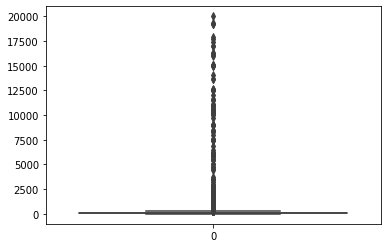

In [25]:
sns.boxplot(data=df['Power']);

Let's remove Power with extreme values. I google around the maximum car power currently is 2080 hp.

In [26]:
df = df[df['Power']<=2080]

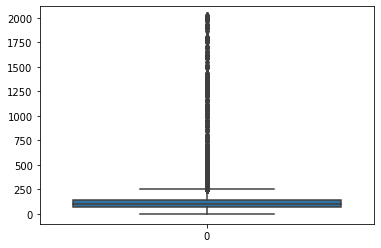

In [27]:
sns.boxplot(data=df['Power']);

RegistrationYear between 1920-2021. Most values are 2000, we gonna make all cars non identify over 2021 to 2000.

In [28]:
def year_corrected(row):
    year = row['RegistrationYear']
    if year <= 1920 :
        return 1920
    elif year > 2021:
        return 2000
    return year

df['RegistrationYear'] = df.apply(year_corrected, axis=1)

Fill the missing values assuming there is correlation between model with brand and registration year.

In [29]:
df['Model'] = df.groupby(['Brand','RegistrationYear'])['Model'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

Fill the missing values assuming there is correlation between vehicle type with brand and model.

In [30]:
df['VehicleType'] = df.groupby(['Brand','Model'])['VehicleType'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

Fill the missing values assuming there is correlation between fuel type with brand and model.

In [31]:
df['FuelType'] = df.groupby(['Brand','Model'])['FuelType'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

Fill the missing values assuming there is correlation between gearbox type with brand and registration year.

In [32]:
df['Gearbox'] = df.groupby(['Brand','RegistrationYear'])['Gearbox'].transform(lambda x: x.fillna((x.mode()[0] if not x.mode().empty else "Empty")))

Replace empty with NaN

In [33]:
df = df.replace('Empty',np.nan)

In [34]:
df.isnull().sum()/len(df)*100

Price                0.000000
VehicleType          0.000565
RegistrationYear     0.000000
Gearbox              0.028228
Power                0.000000
Model                0.960306
Mileage              0.000000
RegistrationMonth    0.000000
FuelType             0.000565
Brand                0.000000
NotRepaired          0.000000
dtype: float64

There is still missing values with max 0.96 % we are going to drop them.

In [35]:
df = df.dropna()

Remove the duplicates.

In [36]:
df = df.drop_duplicates()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 317165 entries, 0 to 354368
Data columns (total 11 columns):
Price                317165 non-null int64
VehicleType          317165 non-null object
RegistrationYear     317165 non-null int64
Gearbox              317165 non-null object
Power                317165 non-null int64
Model                317165 non-null object
Mileage              317165 non-null int64
RegistrationMonth    317165 non-null int64
FuelType             317165 non-null object
Brand                317165 non-null object
NotRepaired          317165 non-null float64
dtypes: float64(1), int64(5), object(5)
memory usage: 29.0+ MB


In [38]:
df.isnull().sum()/len(df)*100

Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Mileage              0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
NotRepaired          0.0
dtype: float64

In [39]:
df.duplicated().sum()

0

No missing values, no duplicates.

In [40]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,0.0
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,1.0
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0.0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0.0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0.0


Copy the dataframe for catboost and lightgbm models without translating categorical data into nominal, since both models support working with categorical data

In [41]:
df_categorical = df.copy()

convert categorical features to nominal using OrdinalEncoder

In [42]:
ordinal_encoder = OrdinalEncoder()
columns = list(df.select_dtypes(include='object').columns)
df[columns] = ordinal_encoder.fit_transform(df[columns].astype('str'))
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,4.0,1993,1.0,0,116.0,150000,0,6.0,37.0,0.0
1,18300,2.0,2011,1.0,190,29.0,125000,5,2.0,1.0,1.0
2,9800,6.0,2004,0.0,163,117.0,125000,8,2.0,14.0,0.0
3,1500,5.0,2001,1.0,75,116.0,150000,6,6.0,37.0,0.0
4,3600,5.0,2008,1.0,69,101.0,90000,7,2.0,31.0,0.0


using OrdinalEncoder.

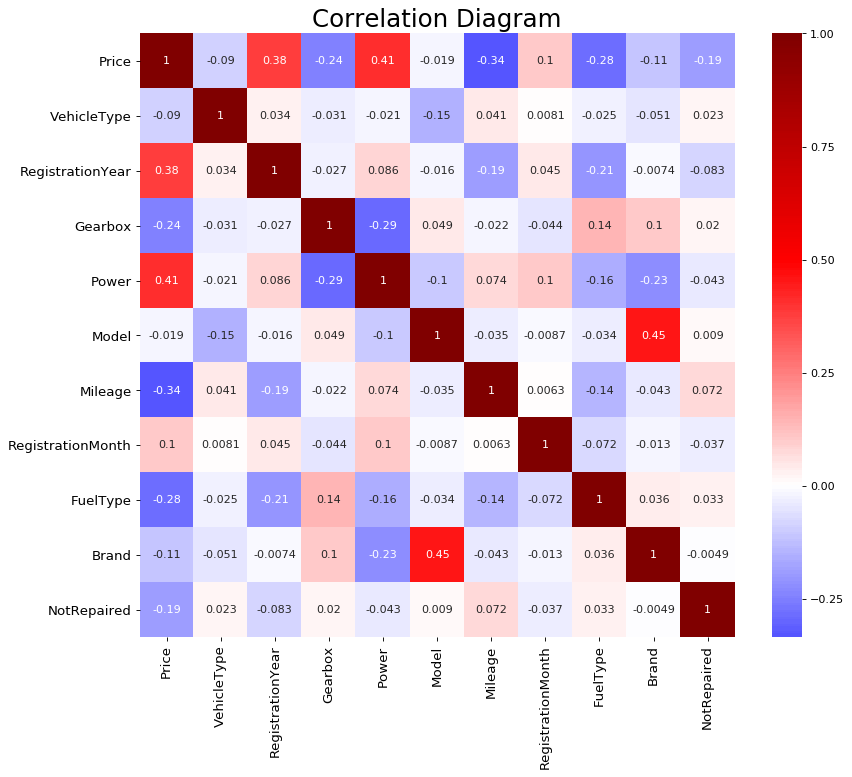

In [43]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='seismic', center=0,
            annot=True)
plt.title('Correlation Diagram', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [44]:
df.corr()['Price'].sort_values(ascending=False)

Price                1.000000
Power                0.410232
RegistrationYear     0.383060
RegistrationMonth    0.103551
Model               -0.019417
VehicleType         -0.089606
Brand               -0.106425
NotRepaired         -0.192047
Gearbox             -0.242031
FuelType            -0.284499
Mileage             -0.335692
Name: Price, dtype: float64

- Power and RegistrationYear have strong positive correlation with Price. 
- Mileage and FuelType has strong negative correlation with price.

Let's look at the distribution of the Price.

In [45]:
df['Price'].mean()

4420.581911623288

2700.0

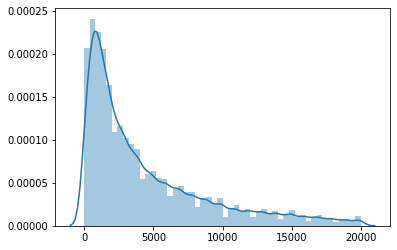

In [46]:
sns.distplot(df['Price'].values)
np.median(df['Price'].values)

### Conclusion

- We drop columns that we don't need which are DateCrawled, DateCreated, LastSeen, PostalCode, NumberOfPictures
- Fill missing values of notrepaired with 0 since since most likely users who filled out the "Was the car repaired" form simply did not fill out if it was not repaired. For this reason, let's assume that the missing values are zero.
- Remove Power with extreme values more than 2080 hp. I google around the maximum car power currently is 2080 hp.
- RegistrationYear between 1920-2021. Most values are 2000, we gonna make all cars non identify over 2021 to 2000.
- Fill the missing values assuming there is correlation between model with brand and registration year.
- Fill the missing values assuming there is correlation between vehicle type with brand and model.
- Fill the missing values assuming there is correlation between gearbox type with brand and registration year.
- Drop the rest of missing values that less than 1% and remove the duplicates
- Convert categorical data into nominal using OrdinalEncoder
- Power and RegistrationYear have strong positive correlation with Price.
- Mileage and FuelType has strong negative correlation with price.
- Price has a right skewed histogram, the median is lower than the mean value.

## Model training <a class="anchor" id="training"></a>

In [47]:
X = df.drop(['Price'], axis=1)
y = df['Price']

X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)
X_train, X_valid, y_train, y_valid = train_test_split(X_1, y_1, test_size=0.25, random_state=12345)

X_1 = X_1.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_1 = y_1.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print('Size of features to train:', X_train.shape)
print('Size of features to validate:', X_valid.shape)
print('Size of features to test:', X_test.shape)

Size of features to train: (178404, 10)
Size of features to validate: (59469, 10)
Size of features to test: (79292, 10)


 Standardizing features using StandardScaler. Fit scaler only on train part and apply it to all parts (train, valid and test) to reduce overfitting.

In [48]:
scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Mileage']
X_train[numeric] = scaler.fit_transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

### Linear Regression

In [49]:
%%time
lr = LinearRegression()
lr.fit(X_train,y_train)
predicted_valid = lr.predict(X_valid)
rmse = mean_squared_error(y_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 3329.253245103698
mean: 4414.943130503669
CPU times: user 114 ms, sys: 81.3 ms, total: 195 ms
Wall time: 157 ms


### Decision Tree Regressor

In [50]:
%%time
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train,y_train)
predicted_valid = dtr_model.predict(X_valid)
rmse = mean_squared_error(y_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 2444.173973580612
mean: 4459.662233657912
CPU times: user 1.06 s, sys: 19.4 ms, total: 1.08 s
Wall time: 1.11 s


### Random Forest Regressor

In [51]:
%%time
rfr_model = RandomForestRegressor(n_estimators=10, random_state=12345)
rfr_model.fit(X_train,y_train)
predicted_valid = rfr_model.predict(X_valid)
rmse = mean_squared_error(y_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 1928.6359729137462
mean: 4466.096608775457
CPU times: user 8.19 s, sys: 78.6 ms, total: 8.27 s
Wall time: 8.29 s


### LGBM Regressor

In [52]:
%%time
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train,y_train)
predicted_valid = lgbm_model.predict(X_valid)
rmse = mean_squared_error(y_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

rmse: 1851.9494118884672
mean: 4437.127052294921
CPU times: user 9.37 s, sys: 91.1 ms, total: 9.46 s
Wall time: 9.49 s


### Cat Boost Regressor

In [53]:
%%time
cbr_model = CatBoostRegressor(loss_function="RMSE", iterations=20)
cbr_model.fit(X_train,y_train)
predicted_valid = cbr_model.predict(X_valid)
rmse = mean_squared_error(y_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

0:	learn: 4433.6233089	total: 72.7ms	remaining: 1.38s
1:	learn: 4351.2923113	total: 174ms	remaining: 1.56s
2:	learn: 4274.4974374	total: 366ms	remaining: 2.07s
3:	learn: 4198.4012093	total: 472ms	remaining: 1.89s
4:	learn: 4128.0833898	total: 663ms	remaining: 1.99s
5:	learn: 4055.5391988	total: 769ms	remaining: 1.79s
6:	learn: 3988.0736260	total: 961ms	remaining: 1.78s
7:	learn: 3924.0967420	total: 1.07s	remaining: 1.6s
8:	learn: 3861.6576661	total: 1.26s	remaining: 1.54s
9:	learn: 3801.7894099	total: 1.36s	remaining: 1.36s
10:	learn: 3742.1805234	total: 1.56s	remaining: 1.27s
11:	learn: 3683.9792289	total: 1.66s	remaining: 1.11s
12:	learn: 3632.4233369	total: 1.85s	remaining: 999ms
13:	learn: 3578.8200961	total: 1.96s	remaining: 840ms
14:	learn: 3528.8527233	total: 2.15s	remaining: 717ms
15:	learn: 3480.3800655	total: 2.26s	remaining: 564ms
16:	learn: 3435.7119719	total: 2.36s	remaining: 417ms
17:	learn: 3391.6484865	total: 2.55s	remaining: 284ms
18:	learn: 3347.3792167	total: 2.66s	r

### XGB Regressor

In [54]:
%%time
xgb_model = XGBRegressor()
xgb_model.fit(X_train,y_train)
predicted_valid = xgb_model.predict(X_valid)
rmse = mean_squared_error(y_valid, predicted_valid)**0.5
print("rmse:", rmse)
print("mean:", pd.Series(predicted_valid).mean())

[19:20:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


rmse: 2058.4020666159354
mean: 4434.68
CPU times: user 11.6 s, sys: 14.3 ms, total: 11.6 s
Wall time: 11.6 s


Linear Regression, DecisionTreeRegressor and CatBoostRegressor are the fastest models. XGBRegressor is the slowest so we are not going to check it. 

The best RMSE value are LGBMRegressor and RandomForestRegressor models. 

In [55]:
def cross_val_score_DecisionTreeRegressor (X1, y1, depth):
    scores = []
    sample_size = int(len(X1)/3)
    for i in range(0, 3, 1):
        valid_indexes = X1.iloc[i:i+sample_size].index
        train_indexes = X1[~(X1.index.isin(valid_indexes))].index
        X_train = X1.iloc[train_indexes]
        X_valid = X1.iloc[valid_indexes]
        y_train = y1.iloc[train_indexes]
        y_valid = y1.iloc[valid_indexes]
        
        model = DecisionTreeRegressor(max_depth=depth,random_state=12345)
        model = model.fit(X_train, y_train)
        predicted_valid = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, predicted_valid)**0.5
        scores.append(rmse)
    return scores

In [56]:
%%time
for depth in range(7,15):
    scores = cross_val_score_DecisionTreeRegressor (X_1, y_1,depth)
    final_score = pd.Series(scores).mean()  
    print("Depth =", depth, ": ", end='')
    print('DecisionTreeRegressor Average model RMSE score:', final_score)
    print('----------------------------------------------')

Depth = 7 : DecisionTreeRegressor Average model RMSE score: 2330.9062675829773
----------------------------------------------
Depth = 8 : DecisionTreeRegressor Average model RMSE score: 2254.891978688553
----------------------------------------------
Depth = 9 : DecisionTreeRegressor Average model RMSE score: 2198.4172047796233
----------------------------------------------
Depth = 10 : DecisionTreeRegressor Average model RMSE score: 2155.04787379654
----------------------------------------------
Depth = 11 : DecisionTreeRegressor Average model RMSE score: 2127.6482528360393
----------------------------------------------
Depth = 12 : DecisionTreeRegressor Average model RMSE score: 2126.7345095167307
----------------------------------------------
Depth = 13 : DecisionTreeRegressor Average model RMSE score: 2132.404681912298
----------------------------------------------
Depth = 14 : DecisionTreeRegressor Average model RMSE score: 2149.896992640079
---------------------------------------

In [57]:
def cross_val_score_RandomForestRegressor (X1, y1, estimators):
    scores = []
    sample_size = int(len(X1)/3)
    for i in range(0, 3, 1):
        valid_indexes = X1.iloc[i:i+sample_size].index
        train_indexes = X1[~(X1.index.isin(valid_indexes))].index
        X_train = X1.iloc[train_indexes]
        X_valid = X1.iloc[valid_indexes]
        y_train = y1.iloc[train_indexes]
        y_valid = y1.iloc[valid_indexes]
        
        model = RandomForestRegressor(n_estimators=estimators,random_state=12345)
        model = model.fit(X_train, y_train)
        predicted_valid = model.predict(X_valid)
        rmse = mean_squared_error(y_valid, predicted_valid)**0.5
        scores.append(rmse)
    return scores

The code below takes long time to fit. It took around 12 minutes.

In [58]:
%%time
for estimators in range(10,81,10):
    scores = cross_val_score_RandomForestRegressor (X_1, y_1, estimators)
    final_score = pd.Series(scores).mean()
    print("Estimators =", estimators, ": ", end='')
    print('RandomForestRegressor Average model RMSE score:', final_score)
    print('----------------------------------------------')

Estimators = 10 : RandomForestRegressor Average model RMSE score: 1938.6245519089653
----------------------------------------------
Estimators = 20 : RandomForestRegressor Average model RMSE score: 1899.7281045887041
----------------------------------------------
Estimators = 30 : RandomForestRegressor Average model RMSE score: 1888.8422301916587
----------------------------------------------
Estimators = 40 : RandomForestRegressor Average model RMSE score: 1883.2513477286957
----------------------------------------------
Estimators = 50 : RandomForestRegressor Average model RMSE score: 1879.517387622154
----------------------------------------------
Estimators = 60 : RandomForestRegressor Average model RMSE score: 1878.0352547344783
----------------------------------------------
Estimators = 70 : RandomForestRegressor Average model RMSE score: 1875.6983429965555
----------------------------------------------
Estimators = 80 : RandomForestRegressor Average model RMSE score: 1874.438336

In [59]:
def LGBM_regressor(X1, y1, estimators):
    model = LGBMRegressor(n_estimators=estimators, random_state=12345)
    model.fit(X_train, y_train)
    predicted_valid = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, predicted_valid)**0.5
    mean = pd.Series(predicted_valid).mean()
    return rmse, mean

In [60]:
%%time
for estimators in range(30,131,10):
    rmse,mean = LGBM_regressor(X_train, y_train,estimators)
    print("Estimators =", estimators, ": ", end='')
    print('LGBMRegressor Average model RMSE score:', rmse)
    print("mean:", mean)
    print('----------------------------------------------')

Estimators = 30 : LGBMRegressor Average model RMSE score: 2051.5214531539364
mean: 4436.929286936918
----------------------------------------------
Estimators = 40 : LGBMRegressor Average model RMSE score: 1969.7892216418174
mean: 4437.102118372737
----------------------------------------------
Estimators = 50 : LGBMRegressor Average model RMSE score: 1932.3703253580136
mean: 4436.63905004305
----------------------------------------------
Estimators = 60 : LGBMRegressor Average model RMSE score: 1905.651056906735
mean: 4436.943811099036
----------------------------------------------
Estimators = 70 : LGBMRegressor Average model RMSE score: 1889.084704947317
mean: 4437.075849963898
----------------------------------------------
Estimators = 80 : LGBMRegressor Average model RMSE score: 1874.811006017952
mean: 4437.118063465909
----------------------------------------------
Estimators = 90 : LGBMRegressor Average model RMSE score: 1861.154389327716
mean: 4437.233830734958
----------------

Let's check what's happened if we don't transform categorical data into nominals since this model can support working with categorical data.

In [61]:
categorical = ['Brand','Model','VehicleType','Gearbox','FuelType']

In [62]:
df_categorical[categorical] = df_categorical[categorical].astype('category')
df_categorical['NotRepaired'] = df_categorical['NotRepaired'].astype('int64')

Let's convert categorical features to the category format.

In [63]:
X_ = df_categorical.drop(['Price'],axis=1)
y_ = df_categorical['Price']

Splitting the data if categorical data is not changed into nominals.

In [64]:
X__1, X__test, y__1, y__test = train_test_split(X_, y_, test_size=0.25, random_state=12345)
X__train, X__valid, y__train, y__valid = train_test_split(X__1, y__1, test_size=0.25, random_state=12345)

X__1 = X__1.reset_index(drop=True)
X__test = X__test.reset_index(drop=True)
y__1 = y__1.reset_index(drop=True)
y__test = y__test.reset_index(drop=True)

In [65]:
scaler = StandardScaler()
numeric = ['RegistrationYear','Power','Mileage']
X__train[numeric] = scaler.fit_transform(X__train[numeric])
X__valid[numeric] = scaler.transform(X__valid[numeric])
X__test[numeric] = scaler.transform(X__test[numeric])

In [66]:
def cat_LGBM_regressor(X1, y1, estimators, categorical_feature=categorical):
    model = LGBMRegressor(n_estimators=estimators, random_state=12345)
    model.fit(X__train, y__train)
    predicted_valid = model.predict(X__valid)
    rmse = mean_squared_error(y__valid, predicted_valid)**0.5
    mean = pd.Series(predicted_valid).mean()
    return rmse, mean

In [67]:
%%time
for estimators in range(30,131,10):
    rmse,mean = cat_LGBM_regressor(X__train, y__train,estimators, categorical_feature=categorical)
    print("Estimators =", estimators, ": ", end='')
    print('LGBMRegressor Average model RMSE score:', rmse)
    print("mean:", mean)
    print('----------------------------------------------')

Estimators = 30 : LGBMRegressor Average model RMSE score: 1919.8407379033395
mean: 4433.930532392918
----------------------------------------------
Estimators = 40 : LGBMRegressor Average model RMSE score: 1860.0310565414682
mean: 4434.434151586283
----------------------------------------------
Estimators = 50 : LGBMRegressor Average model RMSE score: 1833.0297428830513
mean: 4434.771108732444
----------------------------------------------
Estimators = 60 : LGBMRegressor Average model RMSE score: 1816.740838993801
mean: 4434.567055676744
----------------------------------------------
Estimators = 70 : LGBMRegressor Average model RMSE score: 1805.0877488123813
mean: 4434.5599861223
----------------------------------------------
Estimators = 80 : LGBMRegressor Average model RMSE score: 1796.385631864084
mean: 4434.66399184107
----------------------------------------------
Estimators = 90 : LGBMRegressor Average model RMSE score: 1791.137581666682
mean: 4434.369030454713
-----------------

### Conclusion

- Standardizing features using StandardScaler in the train part to reduce overfitting.
- Linear Regression is the fastest model but does not have good RMSE result.
- XGBRegressor is the slowest so we are not going to check it.
- DecisionTreeRegressor and CatBoostRegressor are fast models.
- The best RMSE value are LGBMRegressor and RandomForestRegressor models so we are going to hyperparameter tuning them.
- RandomForestRegressor best estimators are more than 30 estimators but it took long time to fit. 
- We checked what's happened to LGMB Regressor if we don't transform categorical data into nominals since this model can support working with categorical data.. We converted categorical features to the category format, prepare the categorical data for training the model
- The LGBMRegressor with categorical data and categorical_feature hyperparameter tuning had the best result with its RMSE of 1772, and its much quicker (around 27 second) than RandomForestRegressor (around 18 minutes).
- We are going to check LGBMRegressor with estimators 130, RandomForestRegressor with 80 estimators and DecisionTreeRegressor depth of 12.

## Model analysis <a class="anchor" id="analysis"></a>

In [68]:
%%time
dtr_model = DecisionTreeRegressor(max_depth=12,random_state=12345)
dtr_model.fit(X_train,y_train)
predicted_test = dtr_model.predict(X_test)
rmse = mean_squared_error(y_test, predicted_test)**0.5
print("Decision Tree Regressor model rmse:", rmse)
print("Decision Tree Regressor model mean:", pd.Series(predicted_test).mean())

Decision Tree Regressor model rmse: 2096.877077131514
Decision Tree Regressor model mean: 4403.203339111901
CPU times: user 560 ms, sys: 23 µs, total: 560 ms
Wall time: 573 ms


In [69]:
%%time
rfr_model = RandomForestRegressor(n_estimators=80 ,random_state=12345)
rfr_model.fit(X_train,y_train)
predicted_test = rfr_model.predict(X_test)
rmse = mean_squared_error(y_test, predicted_test)**0.5
print("Random Forest Regressor model rmse:", rmse)
print("Random Forest Regressor model mean:", pd.Series(predicted_test).mean())

Random Forest Regressor model rmse: 1855.298215527854
Random Forest Regressor model mean: 4424.9316402239365
CPU times: user 1min, sys: 752 ms, total: 1min 1s
Wall time: 1min 1s


In [70]:
%%time
lgbm_model = LGBMRegressor(n_estimators=130, random_state=12345)
lgbm_model.fit(X_train,y_train)
predicted_test = lgbm_model.predict(X_test)
rmse = mean_squared_error(y_test, predicted_test)**0.5
print("LGBM Regressor model rmse:", rmse)
print("LGBM Regressor model mean:", pd.Series(predicted_test).mean())

LGBM Regressor model rmse: 1829.7873238100603
LGBM Regressor model mean: 4395.522495684329
CPU times: user 3.64 s, sys: 28 ms, total: 3.67 s
Wall time: 3.68 s


Random Forest Regressor model has the best RMSE of 1855 (after cross-validation), but was very slow when calculating the model. In contrast, LGBMRegressor model was fast on calculating and fitting the model and have also good results, with an RMSE value of 1829, it's better rmse compare to Random Forest Regressor and faster.

Trying to improve the LGBM Regressor model with changing the hyperparameter to get better rmse.

In [71]:
%%time
lgbm_model = LGBMRegressor(task='train', 
                        boosting_type='gbdt', 
                        objective='regression', 
                        metric='rmse', 
                        learning_rate=0.5, 
                        verbose=200, 
                        n_estimators= 130,
                        random_state=12345)
lgbm_model.fit(X_train,y_train)
predicted_test = lgbm_model.predict(X_test)
rmse = mean_squared_error(y_test, predicted_test)**0.5
print("LGBM Regressor model rmse:", rmse)
print("LGBM Regressor model mean:", pd.Series(predicted_test).mean())

LGBM Regressor model rmse: 1799.7380278709472
LGBM Regressor model mean: 4395.2299800430965
CPU times: user 2.51 s, sys: 40 ms, total: 2.55 s
Wall time: 2.57 s


(Note: LGBM using categorical data and categorical feature will be evaluate down below after cat boost regressor with categorical data).

By changing hyperparameter, LGBM Regressor has better RMSE value of 1799 than Random Forest Regressor. 

We are going to check again Cat Boost Regressor with hyperparameter to check if it can beat LGBM Regressor RMSE.

The code below takes pretty long time to fit. (around 2 minutes 30 second)

In [72]:
%%time
cbr_model = CatBoostRegressor(loss_function='RMSE', 
                              iterations=500, 
                              learning_rate=0.2, 
                              thread_count=-1, 
                              random_state=18, 
                              max_depth=10, 
                              l2_leaf_reg=3.5)
cbr_model.fit(X_train,y_train, plot=True, eval_set=(X_test, y_test))
predicted_test = cbr_model.predict(X_test)
rmse = mean_squared_error(y_test, predicted_test)**0.5
print("Cat Boost Regressor model rmse:", rmse)
print("Cat Boost Regressor model mean:", pd.Series(predicted_test).mean())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3920.2515594	test: 3901.7927918	best: 3901.7927918 (0)	total: 166ms	remaining: 1m 22s
1:	learn: 3461.9141111	test: 3445.4658256	best: 3445.4658256 (1)	total: 452ms	remaining: 1m 52s
2:	learn: 3104.9171728	test: 3092.8908435	best: 3092.8908435 (2)	total: 660ms	remaining: 1m 49s
3:	learn: 2846.2717573	test: 2836.7260291	best: 2836.7260291 (3)	total: 951ms	remaining: 1m 57s
4:	learn: 2645.4562992	test: 2637.6686123	best: 2637.6686123 (4)	total: 1.25s	remaining: 2m 3s
5:	learn: 2497.1734942	test: 2490.7991331	best: 2490.7991331 (5)	total: 1.45s	remaining: 1m 59s
6:	learn: 2387.8082880	test: 2384.0402868	best: 2384.0402868 (6)	total: 1.66s	remaining: 1m 56s
7:	learn: 2298.2042592	test: 2298.1406863	best: 2298.1406863 (7)	total: 1.95s	remaining: 1m 59s
8:	learn: 2225.7742381	test: 2228.1300027	best: 2228.1300027 (8)	total: 2.15s	remaining: 1m 57s
9:	learn: 2174.2747076	test: 2180.2280135	best: 2180.2280135 (9)	total: 2.44s	remaining: 1m 59s
10:	learn: 2122.8621089	test: 2130.641447

Cat Boost Regressor model can beat LGBM Regressor with the best RMSE 1752.

Let's check what's happened if we don't transform categorical data into nominals since this model can support working with categorical data. 

In [73]:
%%time
cat_cbr_model = CatBoostRegressor(loss_function='RMSE', 
                              iterations=500, 
                              learning_rate=0.2, 
                              thread_count=-1, 
                              random_state=18, 
                              max_depth=10, 
                              l2_leaf_reg=3.5,
                              cat_features=categorical)
cat_cbr_model.fit(X__train,y__train, plot=True, eval_set=(X__test, y__test))
predicted_test = cat_cbr_model.predict(X__test)
rmse = mean_squared_error(y__test, predicted_test)**0.5
print("Categorical Cat Boost Regressor model rmse:", rmse)
print("Categorical Cat Boost Regressor model mean:", pd.Series(predicted_test).mean())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 3898.5611601	test: 3878.3274747	best: 3878.3274747 (0)	total: 1.3s	remaining: 10m 49s
1:	learn: 3433.5617252	test: 3415.1104627	best: 3415.1104627 (1)	total: 2.5s	remaining: 10m 22s
2:	learn: 3070.2106662	test: 3053.0391527	best: 3053.0391527 (2)	total: 3.6s	remaining: 9m 55s
3:	learn: 2814.0442790	test: 2798.3596519	best: 2798.3596519 (3)	total: 4.59s	remaining: 9m 28s
4:	learn: 2602.7436523	test: 2589.8464788	best: 2589.8464788 (4)	total: 5.6s	remaining: 9m 14s
5:	learn: 2447.8691981	test: 2437.2083924	best: 2437.2083924 (5)	total: 6.7s	remaining: 9m 11s
6:	learn: 2328.5827278	test: 2318.4832359	best: 2318.4832359 (6)	total: 7.89s	remaining: 9m 15s
7:	learn: 2245.1850706	test: 2236.0636413	best: 2236.0636413 (7)	total: 8.99s	remaining: 9m 12s
8:	learn: 2172.9513198	test: 2166.8837016	best: 2166.8837016 (8)	total: 10.2s	remaining: 9m 14s
9:	learn: 2111.5503461	test: 2106.1645329	best: 2106.1645329 (9)	total: 11.1s	remaining: 9m 5s
10:	learn: 2065.6025736	test: 2062.7723320	b

Cat Boost Regressor with categorical data has better RMSE result of 1742, compared to Cat Boost Regressor in the previous data (that changed the categorical data into nominal) with RMSE 1752. It means Cat Boost Regressor model is good supporting categorical data and with good result.

Let's trying to fit this categorical data to LGBM Regressor to check if it's better or not than the Cat Boost Regressor above. 

In [74]:
%%time
cat_lgbm_model = LGBMRegressor(task='train', 
                        boosting_type='gbdt', 
                        objective='regression', 
                        metric='rmse', 
                        learning_rate=0.5, 
                        verbose=200,
                        n_estimators=130,
                        random_state=12345,
                        categorical_feature=categorical)
cat_lgbm_model.fit(X__train,y__train)
predicted_test = cat_lgbm_model.predict(X__test)
rmse = mean_squared_error(y__test, predicted_test)**0.5
print("Categorical LGBM Regressor model rmse:", rmse)
print("Catagorical LGBM Regressor model mean:", pd.Series(predicted_test).mean())

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:842: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:863: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Categorical LGBM Regressor model rmse: 1795.4027842012442
Catagorical LGBM Regressor model mean: 4395.3158309606
CPU times: user 2.34 s, sys: 53.4 ms, total: 2.39 s
Wall time: 2.4 s


- Cat Boost Regressor with categorical data has better RMSE result of 1742 than LGBM Regressor with categorical data with RMSE 1795.
- LGBM Regressor with categorical data has better RMSE result of 1795 compare to LGBM Regressor with previous data (that changed categorical to nominal) with RMSE 1799. It means LGBM is good supporting categorical data.
- LGBM Regressor is much faster with around 2.60 second than Cat Boost Regressor with around 10 minutes.

### Conclusion

- Random Forest Regressor model has RMSE of 1855 (after cross-validation), but was very slow when calculating the model.
- LGBMRegressor model was fast on calculating and fitting the model and have also good results, with an RMSE value of 1846, it's very close rmse with Random Forest Regressor but faster.
- We tried to improve the LGBM Regressor model from 1829 RMSE, with changing the hyperparameter to get better RMSE value of 1799, it's also better than Random Forest Regressor. 
- Then we compare it to Cat Boost Regressor model with changing hyperparameters, it can beat LGBM Regressor with the best RMSE 1752.
- We checked what's happened if we don't transform categorical data into nominals since this model can support working with categorical data.
- We converted categorical features to the category format, prepare the categorical data for training the model
- RMSE of Cat Boost Regressor with categorical data is 1742, better than the previous data (that changed the categorical data into nominal). It means Cat Boost Regressor model is good handling and supporting categorical data and with good result. 
- With this categorical data, let's check again LGBM Regressor to check if it's better than the previous Cat Boost Regressor or not. With score RMSE of 1795, it's better than LGBM Regressor with previous data (that changed the catergorical data into nominal), but it still can't beat Cat Boost Regressor with categorical data
- Cat Boost Regressor with categorical data has the best RMSE 1742, even though it's slower than LGBM Regressor.
- LGBM Regressor is very fast compare to other models with around 2.44 second to get RMSE 1795, while it took Cat Boost Regressor around 10 minutes to get RMSE of 1742.

## Overall Conclusion <a class="anchor" id="allconclusion"></a>

- In conclusion Cat Boost Regressor with categorical data is the winner with the best RMSE 1742, even though it's slower than LGBM Regressor.
- LGBM Regressor is very fast and with competitive great RMSE value, so it's also recommended if the time is important and working on large datasets in limited time. 
- Linear Regression is very fast but doesn't have good RMSE.
- almost all models gave us to the same mean of Price 4420, near to the real mean of price. But, since the Price values are differ from each other, with a right skewed histogram, making it that the median 2700 is much lower to the mean value, the models had difficult to predict the correct target value, thus the RMSE was pretty high in all models.